# Code Flow for Training Data

## Observing the Training Data Pattern through Scatter Plots

### Importing requiered Libraries for Visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Importing Data from Folder

In [2]:
data_dir = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\2D Data"
bt_folders = ['B.T. 320', 'B.T. 350', 'B.T. 360', 'B.T. 380', 'B.T. 390', 'B.T. 400']

### Concatenating Data into a Single DataFrame

In [3]:
all_temp_data = [] # Empty list to hold all temperature data

# Loop over folders
for folder in bt_folders:
    folder_path = os.path.join(data_dir, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('temp.csv'):
            file_path = os.path.join(folder_path, filename)
            
            df = pd.read_csv(file_path)
            df.columns = ['x', 'y', 'Temperature'] 
            df['BT'] = int(folder.split('.')[-1]) # Creating the B.C. column
            all_temp_data.append(df)

# Combine all
df = pd.concat(all_temp_data, ignore_index=True)

In [4]:
df.shape

(1738800, 4)

In [5]:
print("Sample temperature data:")
df.head(1391046)

Sample temperature data:


,x,y,Temperature,BT
0,0.096000,0.180003,300.0,320
1,0.096002,0.181001,300.0,320
2,0.095002,0.181004,300.0,320
3,0.094999,0.180003,300.0,320
4,0.095999,0.182005,300.0,320
...,...,...,...,...
1391041,0.000000,0.297000,300.0,390
1391042,0.000000,0.298000,300.0,390
1391043,0.000000,0.299000,300.0,390
1391044,0.000000,0.300000,300.0,390


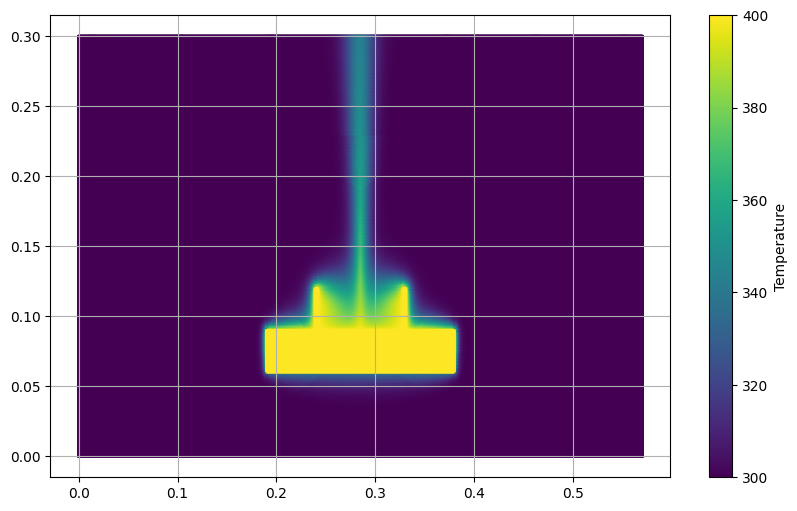

In [6]:
plt.figure(figsize = (10, 6))
plt.scatter(df['x'], df['y'], c = df['Temperature'], cmap = 'viridis', s = 1)
plt.colorbar(label = 'Temperature')
plt.grid(True)
plt.show()

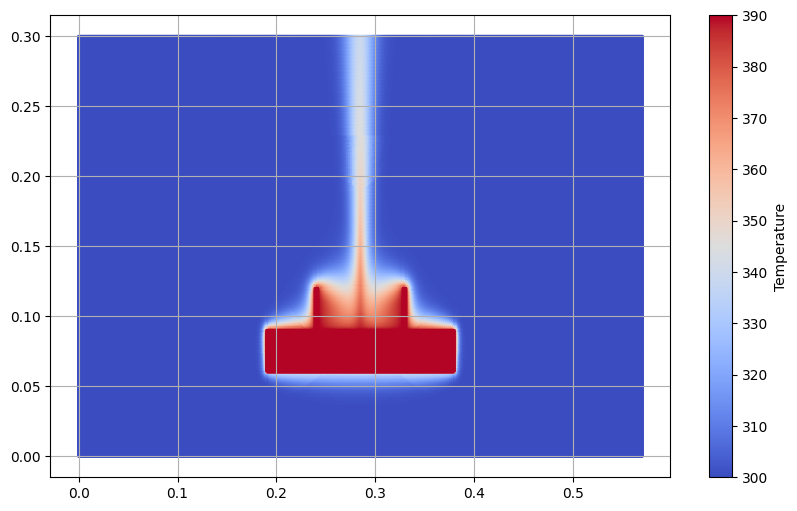

In [7]:
bt_value = 390
df_bt = df[df['BT'] == bt_value]

plt.figure(figsize = (10, 6))
plt.scatter(df_bt['x'], df_bt['y'], c = df_bt['Temperature'], cmap = 'coolwarm', s = 1)
plt.colorbar(label = 'Temperature')
plt.grid(True)
plt.show()

### Scatter Plot of all the Boundary Conditions with Temperature Variation

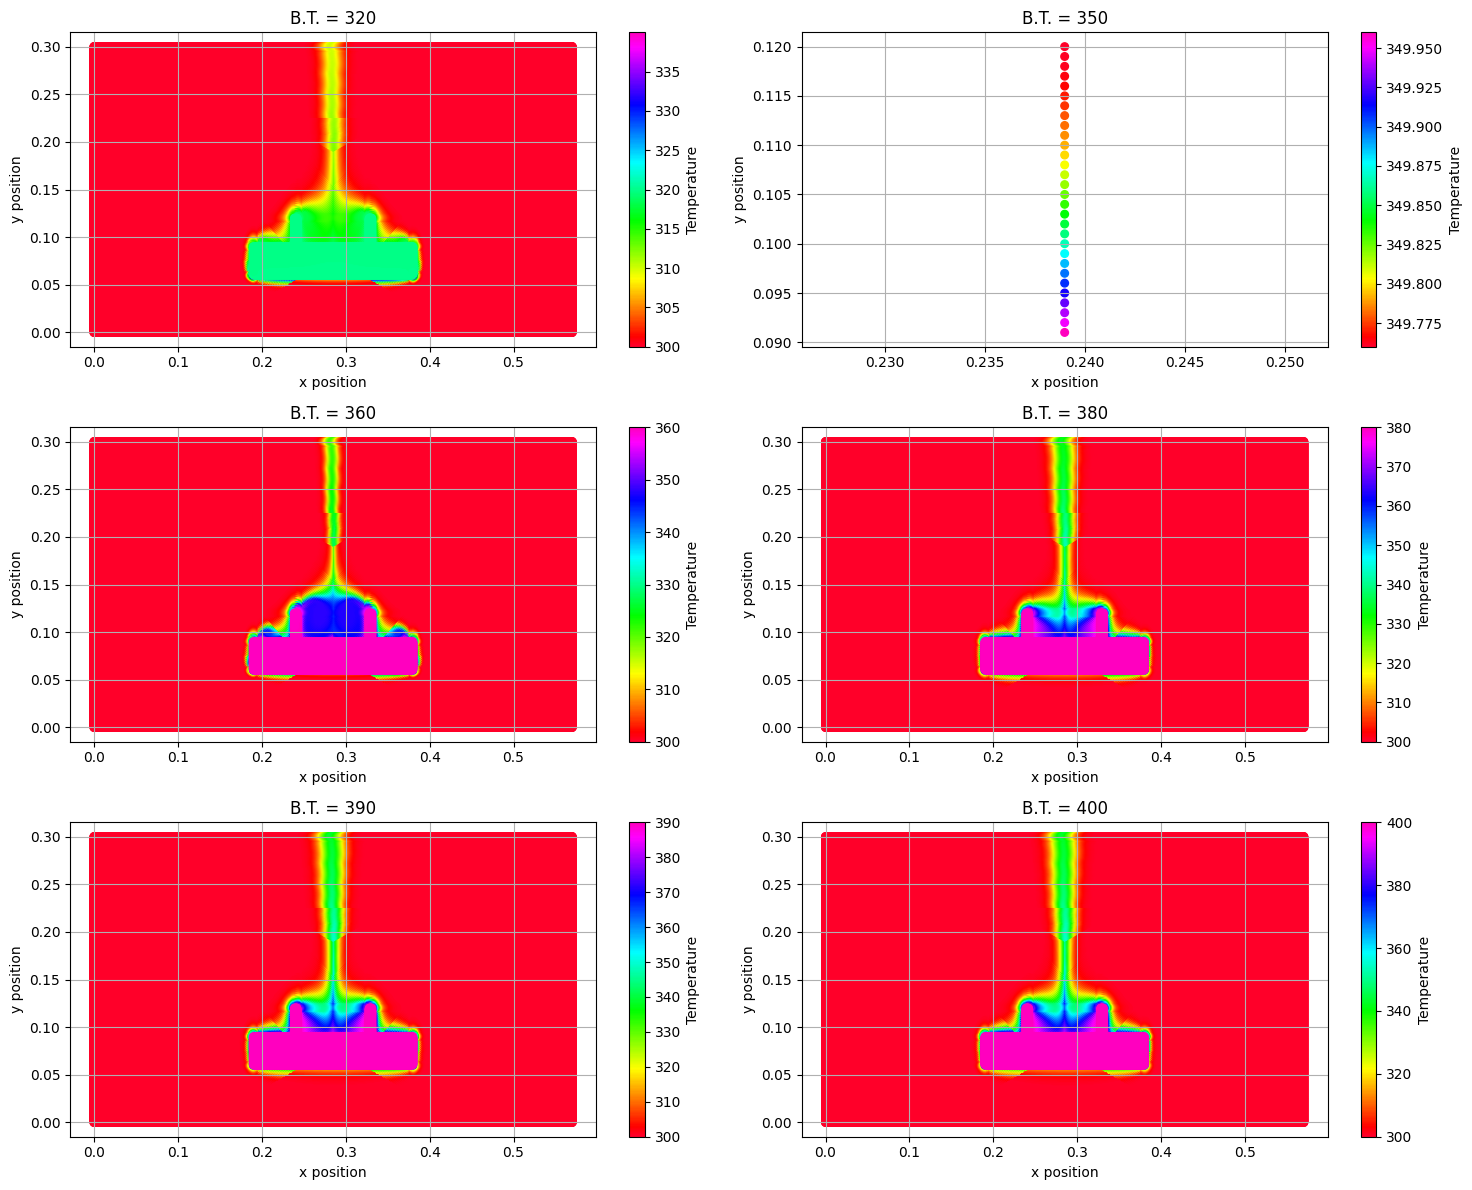

In [8]:
# Get unique boundary conditions sorted
unique_bcs = sorted(df['BT'].unique())

# Set up subplots
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 12))
axes = axes.flatten() # Flatten the 2D array of axes to 1D array

# Loop through B.C.s and plot
for idx, bt_val in enumerate(unique_bcs):
    df_bt = df[df['BT'] == bt_val]
    
    ax = axes[idx]
    scatter = ax.scatter(df_bt['x'], df_bt['y'], c = df_bt['Temperature'], cmap = 'gist_rainbow', s = 30)
    ax.set_title(f'B.T. = {bt_val}')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid(True)
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_label('Temperature')

plt.tight_layout()
plt.show()

## Training and Testing Data Preparation

### Importing requiered Libraries for Training Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.utils import plot_model

### Splitting Data into X and y

In [10]:
X = df[['x', 'y', 'BT']].values # Input parameters
y = df['Temperature'].values # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

x_scaler = RobustScaler() # Used for outliers
# MinMaxScaler() or StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [11]:
X_train.shape, X_train_scaled.shape

((1391040, 3), (1391040, 3))

In [12]:
X_test.shape, X_test_scaled.shape

((347760, 3), (347760, 3))

In [13]:
y_train.shape, y_train_scaled.shape

((1391040,), (1391040,))

In [14]:
y_test.shape, y_test_scaled.shape

((347760,), (347760,))

In [15]:
X_train_scaled.min(), X_train_scaled.max(), y_train.min(), y_train.max()

(-2.0, 1.0035352610600148, 300.0, 400.0)

### Building the ANN Model

In [16]:
def huber_loss(y_true, y_pred, delta = 1.35):
    error = y_true - y_pred
    condition = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(condition, squared_loss, linear_loss)

In [17]:
model = Sequential([
    Dense(256, activation = 'swish', input_shape = (X_train_scaled.shape[1], )), #kernel_regularizer = l1_l2(l1 = 1e-5, l2 = 1e-4)), # Input layer
    BatchNormalization(), 
    Dropout(0.2),
    Dense(128, activation = 'swish'), #kernel_regularizer = l1_l2(l1 = 1e-5, l2 = 1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation = 'swish'), #kernel_regularizer = l1_l2(l1 = 1e-5, l2 = 1e-4)),
    # BatchNormalization(),
    # Dense(64, activation = 'swish'),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(32, activation = 'swish'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation = 'linear')
])

optimizer = Adam(learning_rate = 0.001, clipnorm = 1.0)
model.compile(optimizer = optimizer, loss = 'huber_loss', metrics = [huber_loss, 'mae'])

early_stop = EarlyStopping(patience = 5, min_delta = 0.0001, restore_best_weights = True)
reduce_rl = ReduceLROnPlateau(factor = 0.5, patience = 5, min_lr = 1e-6)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1024      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [18]:
model.fit(X_train_scaled, y_train_scaled, validation_data = (X_test_scaled, y_test_scaled), epochs = 10, batch_size = 64, callbacks = [reduce_rl, early_stop])

Epoch 1/10
21735/21735 [==============================] - 81s 4ms/step - loss: 0.1122 - huber_loss: 0.1309 - mae: 0.2355 - val_loss: 0.0447 - val_huber_loss: 0.0511 - val_mae: 0.1045 - lr: 0.0010
Epoch 2/10
21735/21735 [==============================] - 77s 4ms/step - loss: 0.0807 - huber_loss: 0.0923 - mae: 0.1928 - val_loss: 0.0409 - val_huber_loss: 0.0461 - val_mae: 0.1232 - lr: 0.0010
Epoch 3/10
21735/21735 [==============================] - 80s 4ms/step - loss: 0.0664 - huber_loss: 0.0747 - mae: 0.1806 - val_loss: 0.0354 - val_huber_loss: 0.0395 - val_mae: 0.1183 - lr: 0.0010
Epoch 4/10
21735/21735 [==============================] - 79s 4ms/step - loss: 0.0585 - huber_loss: 0.0652 - mae: 0.1719 - val_loss: 0.0283 - val_huber_loss: 0.0314 - val_mae: 0.1019 - lr: 0.0010
Epoch 5/10
19217/21735 [=========================>....] - ETA: 8s - loss: 0.0547 - huber_loss: 0.0608 - mae: 0.1671

KeyboardInterrupt: 